In [1]:
from __future__ import print_function
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
from my_strategy import Strategy
from my_event import SignalEvent
from my_backtest import Backtest
from my_data import HistoricCSVDataHandler
from my_execution import SimulatedExecutionHandler
from my_portfolio import Portfolio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
class MovingAverageCrossStrategy(Strategy):
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 100/400 periods respectively.
    """
    def __init__(self, bars, events, short_window=20, long_window=50):
        """
        Initialises the Moving Average Cross Strategy.
        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window
        #Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
    
    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to ’OUT’.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
        if event.type == 'MARKET':
            for s in self.symbol_list:
                bars = self.bars.get_latest_bars_values(
                s, "adj_close", N=self.long_window
                )
                bar_date = self.bars.get_latest_bar_datetime(s)
               
                if bars is not None:
               
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])
                    symbol = s
                    dt = datetime.datetime.utcnow()
                    #print(dt)
                    sig_dir = ""
                    if short_sma > long_sma and self.bought[s] == "OUT":
                        print("LONG: %s" % bar_date)
                        print("short-ma: ", short_sma, " long_ma: ", long_sma)
                        sig_dir = 'LONG'
                        signal = SignalEvent(1, symbol, dt, sig_dir, 1.0)
                        self.events.put(signal)
                        self.bought[s] = 'LONG'
                    elif short_sma < long_sma and self.bought[s] == "LONG":
                        print("SHORT: %s" % bar_date)
                        print("short-ma: ", short_sma, " long_ma: ", long_sma)
                        sig_dir = 'EXIT'
                        signal = SignalEvent(1, symbol, dt, sig_dir, 1.0)
                        self.events.put(signal)
                        self.bought[s] = 'OUT'

In [5]:
if __name__ == "__main__":
    csv_dir = 'C:/Users/NickLee/quantstart/my_event_driven' # CHANGE THIS!
    symbol_list = ['SPY']
    initial_capital = 1000000.0
    heartbeat = 0.0
    start_date = datetime.datetime(2010, 6, 11, 0, 0, 0)
    end_date = datetime.datetime(2019, 6, 20, 0, 0, 0)
    backtest = Backtest(
    csv_dir, symbol_list, initial_capital, heartbeat,
    start_date, end_date, HistoricCSVDataHandler, SimulatedExecutionHandler,
    Portfolio, MovingAverageCrossStrategy
    )
    backtest.simulate_trading()
    


Creating DataHandler, Strategy, Portfolio and ExecutionHandler
Backtesting start
LONG: 2010-08-02
short-ma:  90.8038444  long_ma:  90.51684844444445
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=BUY
SHORT: 2010-09-02
short-ma:  90.3255853  long_ma:  90.35193956
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=SELL
LONG: 2010-09-21
short-ma:  91.70881084999999  long_ma:  91.68628313999997
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=BUY
SHORT: 2011-03-23
short-ma:  110.11159364999999  long_ma:  110.11234693999997
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=SELL
LONG: 2011-04-13
short-ma:  111.26809739999999  long_ma:  111.13945267999999
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=BUY
SHORT: 2011-06-06
short-ma:  112.74952350000001  long_ma:  112.78194349999994
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=SELL
LONG: 2011-07-19
short-ma:  111.69523505000002  long_ma:  111.47657514000001
Order: Symbol=SPY, Type=MKT, Quantity=1000, Directio

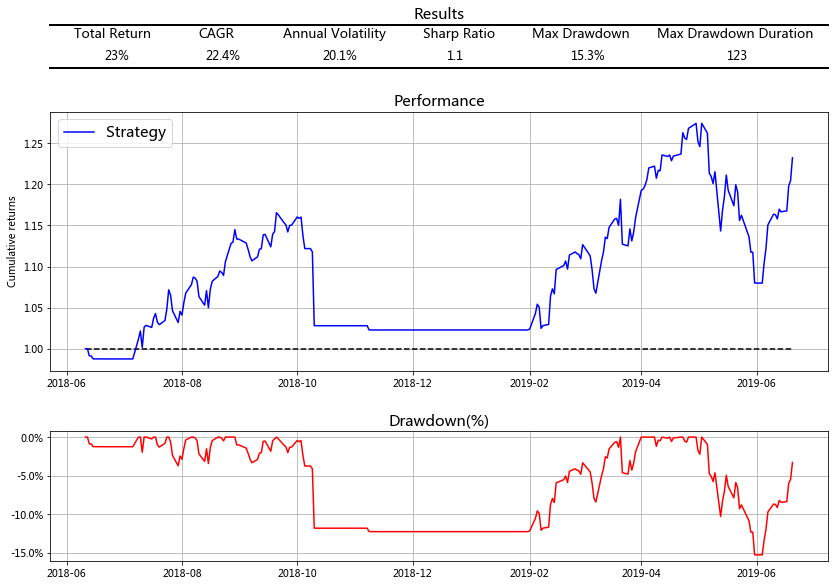

In [12]:
backtest.plot_results()

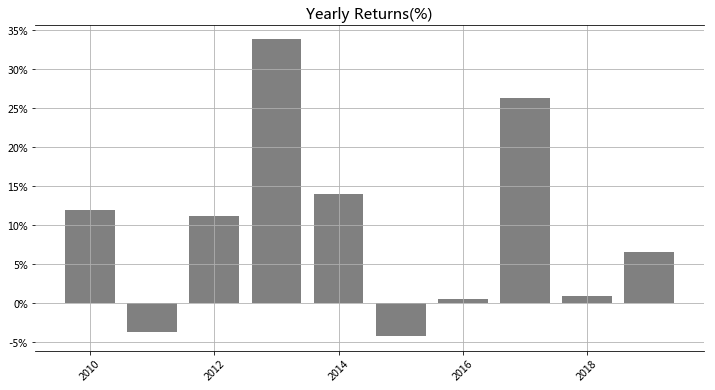

In [7]:
backtest.plot_yearly_returns()

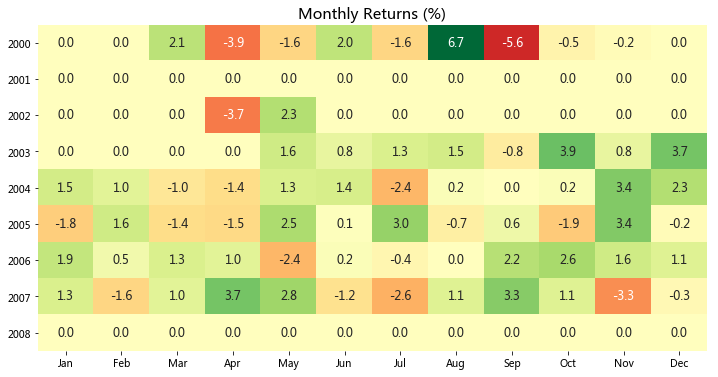

In [6]:
backtest.plot_monthly_returns()